# Data loading

In [1]:
import pandas as pd
import numpy as np
import os
working_directory = os.getcwd()
print(working_directory)

/Users/selesselvan/Documents/DPS


In [2]:
import chardet
def get_file_encoding(file_name):
    with open(file=file_name, mode='rb') as inp:
        encoding= chardet.detect(inp.read(10000))['encoding']
    return encoding

In [51]:
file_path = './220511_monatszahlenmonatszahlen2204_verkehrsunfaelle.csv'

In [86]:
df = pd.read_csv(file_path, sep=',', encoding=get_file_encoding(file_path))

In [5]:
df.shape

(2086, 9)

# EDA

In [7]:
df.head(5)

,MONATSZAHL,AUSPRAEGUNG,JAHR,MONAT,WERT,VORJAHRESWERT,VERAEND_VORMONAT_PROZENT,VERAEND_VORJAHRESMONAT_PROZENT,ZWOELF_MONATE_MITTELWERT
0,Alkoholunfälle,insgesamt,2022,202201,NaN,16.0,NaN,NaN,NaN
1,Alkoholunfälle,insgesamt,2022,202202,NaN,14.0,NaN,NaN,NaN
2,Alkoholunfälle,insgesamt,2022,202203,NaN,24.0,NaN,NaN,NaN
3,Alkoholunfälle,insgesamt,2022,202204,NaN,16.0,NaN,NaN,NaN
4,Alkoholunfälle,insgesamt,2022,202205,NaN,24.0,NaN,NaN,NaN


In [8]:
df.columns

Index(['MONATSZAHL', 'AUSPRAEGUNG', 'JAHR', 'MONAT', 'WERT', 'VORJAHRESWERT',
       'VERAEND_VORMONAT_PROZENT', 'VERAEND_VORJAHRESMONAT_PROZENT',
       'ZWOELF_MONATE_MITTELWERT'],
      dtype='object')

In [9]:
df.MONATSZAHL.unique()

array(['Alkoholunfälle', 'Fluchtunfälle', 'Verkehrsunfälle'], dtype=object)

In [10]:
df.AUSPRAEGUNG.unique()

array(['insgesamt', 'Verletzte und Getötete', 'mit Personenschäden'],
      dtype=object)

In [12]:
df.JAHR.nunique()

23

In [14]:
df.MONAT.nunique()

277

In [16]:
df.WERT.isna().sum()

84

In [17]:
df[df.MONAT == 'Summe'].shape

(154, 9)

# Data Pre-Processing

In [87]:
df = df[['MONATSZAHL', 'AUSPRAEGUNG', 'JAHR', 'MONAT', 'WERT']]

In [88]:
df.isna().sum()

MONATSZAHL      0
AUSPRAEGUNG     0
JAHR            0
MONAT           0
WERT           84
dtype: int64

In [92]:
df.dropna(inplace=True)

In [82]:
df.shape

(2002, 5)

In [90]:
df = df[(df.MONATSZAHL == 'Alkoholunfälle') & (df.AUSPRAEGUNG == 'insgesamt')]

In [91]:
df = df[df.MONAT != 'Summe']

In [94]:
from tqdm import tqdm
tqdm.pandas()

def split_month(monat_entry):
    _, month_field = monat_entry[0:4], monat_entry[4:]
    return pd.Series([month_field])

df[['MONAT']] = df.MONAT.progress_apply(split_month)

100%|██████████| 264/264 [00:00<00:00, 13877.28it/s]


In [95]:
df.head(5)

,MONATSZAHL,AUSPRAEGUNG,JAHR,MONAT,WERT
13,Alkoholunfälle,insgesamt,2021,01,16.0
14,Alkoholunfälle,insgesamt,2021,02,14.0
15,Alkoholunfälle,insgesamt,2021,03,24.0
16,Alkoholunfälle,insgesamt,2021,04,16.0
17,Alkoholunfälle,insgesamt,2021,05,24.0


In [149]:
working_df = df[df.JAHR <= 2020]
ground_truth_df = df[df.JAHR > 2020]
working_df.shape, ground_truth_df.shape

((252, 5), (12, 5))

# Visualization

# Statistical Testing

## The reason behind this statistical testing

As the data is based on alcohol related accidents, I have a hypothesis that there could be a seasonal pattern in the data. Because, as alcohol keeps our body warm, people might tend to consume more alcohol during the winter period, which will lead to an increased amount of accidents due to alcohol consumption. In order to test this hypothesis, I resort to Augmented Dickey Fuller test for stationarity in the data. The null hypothesis of this test assumes there is no stationarity in the data. Should we fail to reject this null hypothesis, we can conclude that there **could be** a season pattern in the data.

In [97]:
from statsmodels.tsa.stattools import adfuller
adft = adfuller(df[['WERT']],autolag="AIC")

output_df = pd.DataFrame({"Values":[adft[0],adft[1],adft[2],adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']]  , "Metric":["Test Statistics","p-value","No. of lags used","Number of observations used", 
                                                        "critical value (1%)", "critical value (5%)", "critical value (10%)"]})
print(output_df)

       Values                       Metric
0    1.670824              Test Statistics
1    0.998055                      p-value
2   11.000000             No. of lags used
3  252.000000  Number of observations used
4   -3.456569          critical value (1%)
5   -2.873079          critical value (5%)
6   -2.572919         critical value (10%)


We can see that our data is not stationary from the fact that our p-value is greater than 5 percent and the test statistic is greater than the critical value. We can also draw these conclusions from inspecting the data, as we see a clear, increasing trend in the WERT.

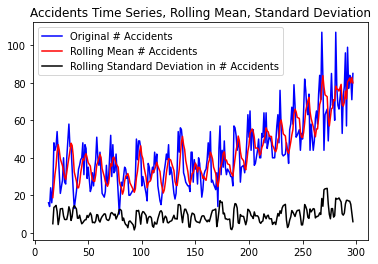

In [107]:
import matplotlib.pyplot as plt


rolling_mean = df[['WERT']].rolling(5).mean()
rolling_std = df[['WERT']].rolling(5).std()
plt.plot(df[['WERT']], color="blue",label="Original # Accidents")
plt.plot(rolling_mean, color="red", label="Rolling Mean # Accidents")
plt.plot(rolling_std, color="black", label = "Rolling Standard Deviation in # Accidents")
plt.title("Accidents Time Series, Rolling Mean, Standard Deviation")
plt.legend(loc="best")

# Statistical Modeling

In [109]:
!pip install pmdarima

     |████████████████████████████████| 604 kB 3.8 MB/s eta 0:00:01


In [114]:
working_df.WERT

26     28.0
27     40.0
28     27.0
29     26.0
30     40.0
       ... 
293    77.0
294    84.0
295    83.0
296    71.0
297    85.0
Name: WERT, Length: 252, dtype: float64

In [115]:
from pmdarima.arima import auto_arima

model = auto_arima(working_df.WERT, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(working_df.WERT)
forecast = model.predict(n_periods=len(ground_truth_df.WERT))
forecast = pd.DataFrame(forecast,index = ground_truth_df.WERT.index,columns=['Prediction'])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1990.626, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1952.351, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1944.274, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1988.706, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1915.901, Time=0.07 sec


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/opt/anaconda3/lib/python3.9/site-p

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1914.760, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1948.722, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1915.948, Time=0.14 sec


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1949.977, Time=0.07 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1917.297, Time=0.06 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0] intercept
Total fit time: 1.277 seconds


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


In [144]:
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error

rms = sqrt(mean_squared_error(ground_truth_df.WERT, forecast))
mae = mean_absolute_error(ground_truth_df.WERT, forecast)
print("RMSE: ", rms)
print('MAE: ', mae)

RMSE:  47.78267487700012
MAE:  45.68159770739165


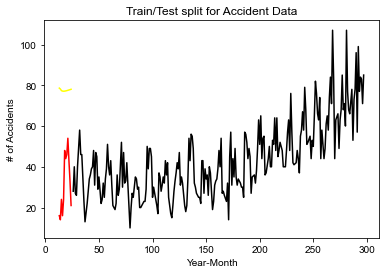

In [119]:
import seaborn as sns 

plt.plot(working_df.WERT, color = "black")
plt.plot(ground_truth_df.WERT, color = "red")
plt.plot(forecast, color = "yellow")
plt.title("Train/Test split for Accident Data")
plt.ylabel("# of Accidents")
plt.xlabel('Year-Month')
sns.set()
plt.show()

# Machine Learning Model for prediction

### Model Selection

In [140]:
!pip install 'pycaret[full]'
# !pip install Jinja2
# !pip install 'markupsafe'

  Using cached pycaret-2.3.10-py3-none-any.whl (320 kB)
     |████████████████████████████████| 167 kB 3.4 MB/s eta 0:00:01
     |████████████████████████████████| 2.3 MB 4.7 MB/s eta 0:00:01
  Using cached scikit-learn-0.23.2.tar.gz (7.2 MB)
  Installing build dependencies ... error
  ERROR: Command errored out with exit status 1:
   command: /opt/anaconda3/bin/python /private/var/folders/x6/gp1ykdrx2vzg7bxn06yyz0lc0000gn/T/pip-standalone-pip-7ukl6eg9/__env_pip__.zip/pip install --ignore-installed --no-user --prefix /private/var/folders/x6/gp1ykdrx2vzg7bxn06yyz0lc0000gn/T/pip-build-env-f4tjia9m/overlay --no-warn-script-location --no-binary :none: --only-binary :none: -i https://pypi.org/simple -- setuptools wheel 'Cython>=0.28.5' 'numpy==1.13.3; python_version=='"'"'3.6'"'"' and platform_system!='"'"'AIX'"'"' and platform_python_implementation == '"'"'CPython'"'"'' 'numpy==1.14.0; python_version=='"'"'3.6'"'"' and platform_system!='"'"'AIX'"'"' and platform_python_implementation != '"

In [141]:
from pycaret.regression import *
# initialize setup
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(working_df, test_size=0.2)
s = setup(data = working_df, test_data = ground_truth_df, target = 'WERT', fold_strategy = 'timeseries', numeric_features = ['Year', 'Series'], fold = 3, transform_target = True, session_id = 123)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.9/site-packages/pandas/compat/_optional.py", line 138, in import_optional_dependency
    module = importlib.import_module(name)
  File "/opt/anaconda3/lib/python3.9/importlib/__init__.py", line 127, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
  File "<frozen importlib._bootstrap>", line 1030, in _gcd_import
  File "<frozen importlib._bootstrap>", line 1007, in _find_and_load
  File "<frozen importlib._bootstrap>", line 986, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 680, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 850, in exec_module
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
  File "/opt/anaconda3/lib/python3.9/site-packages/jinja2/__init__.py", line 8, in <module>
    from .environment import Environment as Environment
  File "/opt/anaconda3/lib/python3.9/site-packages/jinja2/environment

In [142]:
best = compare_models(sort = 'MAE')

NameError: name 'compare_models' is not defined

### Hyper parameter tuning

In [147]:
!pip install lightgbm

In [ ]:
from sklearn.model_selection import GridSearchCV, RepeatedKFold
import lightgbm as lgb

params = {
    'n_estimators': [400, 700, 1000, 2000],
    'max_depth': [5, 10, 15, 20, 25],
    'num_leaves': [2**2, 2**3, 2**4, 2**5],
    # 'reg_alpha': [1.1, 1.2, 1.3],
    # 'reg_lambda': [1.1, 1.2, 1.3],
    'learning_rate': [0.1, 0.05, 0.005, 0.001],
    'boosting_type': ['dart', 'gbdt']
}

model = lgb.LGBMClassifier()
grid_cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=1234)
clf = GridSearchCV(estimator = model, param_grid=params, cv=grid_cv)
clf.fit(X_iris, y_iris)
GridSearchCV(estimator=SVC(), param_grid={'C': [1, 10], 'kernel': ('linear', 'rbf')})

In [ ]:
import lightgbm as lgb

params = {
    'n_estimators': 2000,
    'max_depth': 4,
    'num_leaves': 2**4,
    'learning_rate': 0.1,
    'boosting_type': 'dart'
}

model = lgb.LGBMRegressor(first_metric_only = True, **params)

model.fit(train_x, train_y,
          eval_metric = 'l1', 
          eval_set = [(test_x, test_y)],
          #early_stopping_rounds = 10,
          verbose = 0)

# Generalization Error with Ground Truth Data